In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
# Only run if you want to use google drive inside the notebook.
from google.colab import drive
drive.mount('/content/drive')

# Parameters

In [2]:
#@title Path to directory containing filtered files and config file
DIR = "data/DailyDialog/baseline/filtered_data/"  #@param {type:"string"}

# Setup
Run some setup code and define the functions that will be used later.

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy as np
import operator

from config import Config


# Load config file from specified directory
Config.load_config = DIR
config = Config()
config.load()

plt.rcParams.update({'font.size': 14})

In [4]:
# Visualization function for the clustering data.
def _visualize(file, tag, fig_list):
  '''
  Params:
    :file: Clustering file, from which to read data.
    :tag: Can be 'Source' or 'Target'.
    :fig_list: A list containing the plots, which we will draw.
  '''
  sentence_entropy = []
  entropies_all = []
  entropies = []
  sentence_cl_size = []
  cl_sizes_all = []
  cl_sizes = []
  lengths = []

  for line in file:
    [sentence, entropy, cl_size] = line.split(';')
    entropy = float(entropy)
    cl_size = int(cl_size)

    # Populate the lists.
    sentence_entropy.append([sentence, entropy])
    entropies_all.extend([entropy] * cl_size)
    entropies.append(entropy)
    sentence_cl_size.append([sentence, cl_size])
    cl_sizes_all.extend([cl_size] * cl_size)
    cl_sizes.append(cl_size)
    lengths.append(len(sentence.split()))

  # Draw the plots, and set properties.
  fig_list[0].plot(sorted(entropies_all))
  fig_list[0].set_xlabel('Sentence no.')
  fig_list[0].set_ylabel('Entropy')
  #fig_list[0].axis([0, 90000, -0.2, 9])

  fig_list[1].plot(sorted(cl_sizes_all))
  fig_list[1].set_xlabel('Sentence no.')
  fig_list[1].set_ylabel('Cluster size')
  #fig_list[1].axis([0, 90000, -0.2, 500])

  fig_list[2].scatter(np.array(cl_sizes), np.array(entropies))
  fig_list[2].set_xlabel('Cluster size')
  fig_list[2].set_ylabel('Entropy')
  #fig_list[2].axis([0, 320, -0.2, 9])

  fig_list[3].scatter(np.array(lengths), np.array(entropies))
  fig_list[3].set_xlabel('No. of words in utterance')
  fig_list[3].set_ylabel('Entropy')
  #fig_list[3].axis([-0.2, 30, -0.2, 10])

  # Sort the sentence lists.
  sent_ent = sorted(sentence_entropy, key=operator.itemgetter(1), reverse=True)
  sent_cl = sorted(sentence_cl_size, key=operator.itemgetter(1), reverse=True)
  return sent_ent, sent_cl

In [5]:
# Main function to visualize clustering/filtering results.
def data_visualization():
  # Open the clustering files.
  source_cl_entropies = open(os.path.join(config.project_path, config.output_dir, 'fullSource_cluster_entropies.txt'))
  target_cl_entropies = open(os.path.join(config.project_path, config.output_dir, 'fullTarget_cluster_entropies.txt'))

  # Set up matplotlib.
  plt.close('all')
  fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2)
  fig.set_size_inches(13, 20)

  # Call the actual visualization function for source and target data.
  source_entropies, source_cl_sizes = _visualize(source_cl_entropies,
                                                 'Source',
                                                 [ax1, ax3, ax5, ax7])
  target_entropies, target_cl_sizes = _visualize(target_cl_entropies,
                                                 'Target',
                                                 [ax2, ax4, ax6, ax8])
  plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

  source_cl_entropies.close()
  target_cl_entropies.close()

In [10]:
def print_clusters(tag, top_clusters):
  clusters = {}
  cluster_element_lengths = {}

  with open(os.path.join(config.project_path, config.output_dir, 'full{}_cluster_elements.txt'.format(tag))) as file:
    for line in file:
      [source, source_cl_target, target_cl] = line.split('<=====>')

      if tag == 'Source':
        source_cl = source.split(';')[1]
        target_cl_ind = target_cl.split(':')[1].strip('\n')
        source = source_cl_target.split('=')[0]
        target = source_cl_target.split('=')[1]
        cluster_element_lengths[source_cl] = \
            cluster_element_lengths.get(source_cl, 0) + len(source.split())
        clusters[source_cl] = [*clusters.get(source_cl, []), source]

      else:
        target_cl = source.split(';')[1]
        target = source_cl_target.split('=')[0]
        cluster_element_lengths[target_cl] = \
            cluster_element_lengths.get(target_cl, 0) + len(target.split())
        clusters[target_cl] = [*clusters.get(target_cl, []), target]

  with open(os.path.join(config.project_path, config.output_dir, 'full{}_cluster_entropies.txt'.format(tag))) as file:
    entropies = {}
    for line in file:
      [medoid, entropy, size] = line.split(';')
      entropies[medoid] = float(entropy)

  num_removed = 0
  num_all = 0
  for medoid in cluster_element_lengths:
    num_all += len(clusters[medoid])
    if ((cluster_element_lengths[medoid] / len(clusters[medoid]) if
        len(clusters[medoid]) > 0 else 1) > 1000 or
            len(medoid.split()) > 1000 or
            entropies[medoid] < config.threshold):
      num_removed += len(clusters[medoid])

  #print(num_removed / num_all)
  for _, medoid in zip(range(top_clusters),
                       sorted(list(clusters), key=lambda x: entropies[x],
                              reverse=True)):
    print('=====================================================')
    #print('{}& {} & {} \\\\'.format(list(set(clusters[medoid]))[0], len(clusters[medoid]), str(entropies[medoid])[:4]))
    print('Center: {}'.format(medoid))
    print('Entropy: {}'.format(entropies[medoid]))
    print('Size: {}'.format(len(clusters[medoid])))
    if len(clusters[medoid]) < 1000:
      print('Elements: \n{}\n\n'.format('\n'.join(set(clusters[medoid]))))

# Visualize the clustering.
Graphs on the left are about source data, and on the right the target data.
* First the entropy of all the utterances in the dataset is plotted.
* Second each sentence's cluster's size is plotted (for all sentences in the dataset).
* Third the entropy and cluster size of all clusters is plotted
* Finally the relationship between the entropy of an utterance and the number of words in it is plotted.

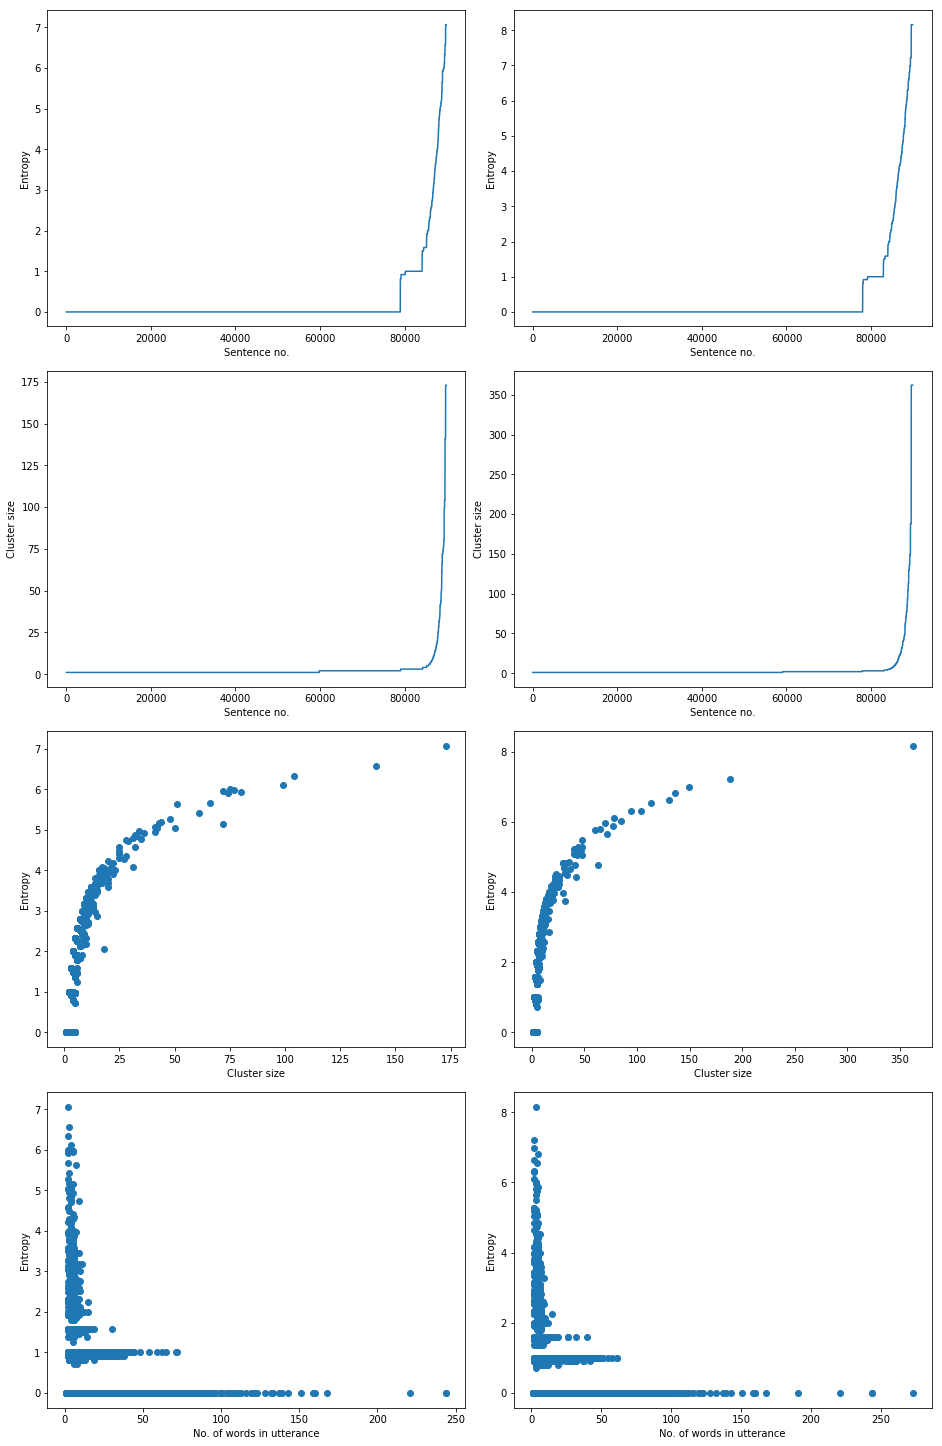

In [15]:
data_visualization()

# Print some clusters
Let's see the unique elements of the clusters with highest entropy.

In [13]:
print_clusters(tag='Source', top_clusters=10)

Center: so dick how about getting some coffee for tonight ?
Entropy: 2.3204735011414868
Size: 23
Elements: 
i do not care the brand as long as it works well .
no the steak was recommended but it is not very fresh .
i have this list of stuff that i need and i only have half the dough .
half the dough huh . well . how would you like to earn the other half ?
would you care for a drink before you order ?
yes i have many things to buy . i would like to choose the cleaning milk first .
i want to buy the toothpaste the brand of jiajieshi .
not today honey . do n't eat too much ice cream .
sounds good . what about shampoo ? i would like to buy the product that prevents scurf .
yes very . believe it or not it will cost you more than one hundred dollars .
mom can i have some ice cream ?
i want to buy more books .
i just happen to have a question for you guys . why do the chinese cook the vegetables ? you see what i mean is that most vitamin are destroyed when heated .
is that expensive ?
i need 